<a href="https://colab.research.google.com/github/keranrong/MITBrain_DeepLearningTutorial/blob/master/convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks tutorial

**Authors:** Eugenio Piasini and Yen-Ling Kuo for the [Brains, Minds and Machines summer course 2018](http://cbmm.mit.edu/summer-school/2018).

This tutorial will show you how
* Build, train and test a neural network in [PyTorch](https://pytorch.org/)
* Work with convolutions
* Visualize filters and other properties as the network during training

To do the above, we will build a convolutional neural network with the purpose of classifying handwritten digits from the MNIST database.


In [0]:
# import modules we will use for the tutorial
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# install and import torch-related modules
!pip3 install torch torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision

# detect if a GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

Running on device: cuda:0


## Set up TensorBoard

[Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) is a utility to record and visualize the activations, weights, loss, etc of your network, during and after training. It greatly simplifies debugging and iterative development of the network architecture. It is highly recommended.

To use TensorBoard in this notebook, we have to overcome two technical hurdles:
 1. we will be using [PyTorch](https://pytorch.org/) to work with our networks, but as the name suggests, TensorBoard is designed to work with [TensorFlow](https://www.tensorflow.org/), a competing framework.
 2. generally it is easiest to use TensorBoard when you're working on your local computer or on a computer on your local network, but in this tutorial we will run these notebooks on remote virtual machines via Colab.

It is not important that you understand exactly how we are getting around these issues (this is not the point of the tutorial!), but the code is below for your reference. We will be using a tool called [`tensorboardx`](https://github.com/lanpa/tensorboardX) ([documentation](https://tensorboardx.readthedocs.io/en/latest/?badge=latest)) to overcome problem 1, and one called `ngrok` to deal with problem 2. If you're running this on your local computer, you only need to worry about problem 1 and `tensorboardx`, and can safely disregard `ngrok`.

After running the following cell, a link should appear, that you can follow to see your newly created TensorBoard interface.

In [0]:
# download and unzip 'ngrok', the tool we will use to set up the tunnel
ngrok_filename = 'ngrok-stable-linux-amd64.zip'
!if [ ! -f $ngrok_filename ]; then wget https://bin.equinox.io/c/4VmDzA7iaHb/$ngrok_filename && unzip $ngrok_filename; fi

# specify where we will write the logging data files to be read by TensorBoard
LOG_DIR = './runs'

# ensure the selected directory exists
!mkdir -p $LOG_DIR

# start TensorBoard
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

# open the tunnel with ngrok
get_ipython().system_raw('./ngrok http 6006 &')

# display a link to the TensorBoard URL
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Public TensorBoard URL: {}'.format(json.load(sys.stdin)['tunnels'][0]['public_url']))"
    
# set up tensorboardx, which we will use to log stuff from pytorch
!pip3 install tensorboardX
from tensorboardX import SummaryWriter

--2018-08-18 15:50:49--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.0.104.144, 34.239.63.98, 34.238.48.57, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.0.104.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  7.71MB/s    in 0.7s    

2018-08-18 15:50:50 (7.71 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Public TensorBoard URL: http://c5b4271e.ngrok.io
    100% |████████████████████████████████| 71kB 5.2MB/s 


## The MNIST database

[The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) is a simple computer vision dataset. 
- It consists of images of handwritten digits from 0-9, and their image labels;
- Each image is 28px * 28px;
- The dataset is divided in two subsets, a "training" one containing 50000 samples and a "testing" one containing 10000 samples.
<p><img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" alt="MNIST sample images."><br>Sample MNIST images. Image by <a href="//commons.wikimedia.org/w/index.php?title=User:Jost_swd15&amp;action=edit&amp;redlink=1" class="new" title="User:Jost swd15 (page does not exist)">Josef Steppan</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=64810040">Link</a></p>

How do we load the images and their labels to train and test our models? As with other important datasets, PyTorch has [a convenient interface](https://pytorch.org/docs/stable/torchvision/datasets.html#) that simplifies our life. We want to use this interface to create "data loaders" that will enable us to access the data. We will actually do it twice for the training set, as we want to make sure all data we use for training and testing the network is normalized. Because of this, we'll load the training data first, compute the average and the standard deviation across all pixels in the dataset, and use those numbers to define new `train` and `test` data loaders that will automatically normalize all data going forward.

In [0]:
# note that PyTorch will automatically download the data from the internet the
# first time we ask it to load it. Hence we have to specify where it should keep
# the data
data_folder = "./data"

# define a data loader that we will only use to compute mean and standard
# deviation on the training set, with the purpose of normalizing all data
trainset_unnormalized = torchvision.datasets.MNIST(root=data_folder, train=True,
                                                  download=True, transform=torchvision.transforms.ToTensor())
unnormalized_loader = torch.utils.data.DataLoader(trainset_unnormalized,
                                                  batch_size=1000)

Processing...
Done!


Before continuing, let's have a look at our raw data to see if it actually looks like hadwritten digits.

True labels for the images below: 5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7


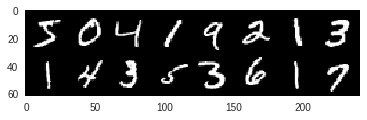

In [0]:
def imshow(img, ax=None):
  """Plot a PyTorch image using matplotlib"""
  npimg = img.numpy()
  if ax is None:
    fig, ax = plt.subplots()
  npimg = np.transpose(npimg, (1,2,0)) # this is needed as torch uses a (channel, height, width) representation while matplotlib usees (width, height, channel)
  
  npimg = (npimg - npimg.min(axis=(0,1)))/(npimg.max(axis=(0,1))-npimg.min(axis=(0,1))) # map the values to the interval [0,1] for each channel
  ax.imshow(npimg)
  ax.grid(False)

# load one batch of images from the training set
dataiter = iter(unnormalized_loader)
images, labels = dataiter.next()

# it will be useful, in the next cell, to be sure of the size of the images
# (we know MNIST is 28x28 but it's better to make sure). In pytorch, batches of
# data are organized as follows: (batch, channels, height, width), so if we want
# the total number of pixels we have to multiply entries 2 and 3 of the size tuple
# (remember that python uses 0-indexing)
n_pixels = images.size()[2]*images.size()[3]

# only keep the first 16 items of the minibatch for ease of visualization
images = images[:16]
labels = labels[:16]

# print labels
print('True labels for the images below:', ' '.join(('{}'.format(j) for j in labels)))

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
# iterate over the training images, keeping a running average of the pixel value
# and their second power. We are performing this iteration in batches of 1000
# images at the time (controlled by the batch_size parameter in the line above).
# Strictly speaking this is unnecessary as the whole dataset can easily fit into
# memory, but we'll do it anyway to show how to iterate over a dataset in
# batches using a data loader.
n_total_images = len(trainset_unnormalized)
train_mean = 0
train_mean_squares = 0
for i, data in enumerate(unnormalized_loader):
  images, labels = data
  train_mean += images.sum()/(n_total_images*n_pixels)
  train_mean_squares += images.pow(2).sum()/(n_total_images*n_pixels)
  
train_std = (train_mean_squares-train_mean.pow(2)).sqrt()

# now that we have the mean and the standard deviation, define the data loaders
# we'll actually use such that the data will be automatically standardized at
# load time.

load_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize((train_mean,), (train_std,))])

trainset = torchvision.datasets.MNIST(root=data_folder, train=True,
                                      download=True, transform=load_transform)
testset =  torchvision.datasets.MNIST(root=data_folder, train=False,
                                      download=True, transform=load_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

## Define and instantiate the network

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # in PyTorch, we often specify all layers of the network that require hyperparameters
    # by creating them here inside __init__. The connections between layers will
    # be established below, inside the forward() method. Note that the order in
    # which we create them here does not matter, as the connections between them
    # will be specified by the forward() method below.
    self.conv1 = nn.Conv2d(in_channels=1, padding=2, out_channels=32, kernel_size=5) # what is the output size?
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # what is the output size?
    self.conv2 = nn.Conv2d(in_channels=32, padding=2, out_channels=64, kernel_size=5)# what is the output size?
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # what is the output size?
    self.fc1 = nn.Linear(in_features=64*7*7, out_features=1024) # where is the value passed as the in_features argument coming from?
    self.fc2 = nn.Linear(in_features=1024, out_features=10)
    self.dropout = nn.Dropout(p=0.5)
    
  def forward(self, x):
    # this method specifies how the network processes its inputs - in other words, it describes the network's connectivity.
    
    # first convolution, followed by ReLU nonlinearity and pooling
    x = self.pool1(F.relu(self.conv1(x)))
    
    # second convolution, followed by ReLU nonlinearity and pooling    
    x = self.pool2(F.relu(self.conv2(x)))
    
    # reshape layer (concatenate all features, removing their "topographic" arrangement)
    x = x.view(-1, 64*7*7)
    
    # first fully connected layer (with ReLU nonlinearity)
    x = F.relu(self.fc1(x))
    
    # dropout (regularization)
    x = self.dropout(x)
    
    # second fully connected layer
    x = self.fc2(x)
    
    # softmax ("squashing nonlinearity") operation. This maps all values to the 
    # [0,1] interval, so that the final output can be interpreted as the 
    # probability of belonging to each of the 10 classes. Note that here, for 
    # easier later processing, we're actually computing the log of the softmax,
    # so the outputs can be interpreted as log-probabilities.
    x = F.log_softmax(x, dim=1)
    
    return x

In [0]:
# instantiate network
net = Net()

# move network to GPU if available
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)

## Define useful functions for visualization



In [0]:
def make_filter_image(layer, use_color=True, scale_each=True):
  """Build an image of the weights of the filters in a given convolutional layer."""
  weights = layer.weight.data.to("cpu")
  if not use_color:
    n_input_channels = weights.size()[1]
    weights = weights.view([weights.size()[0], 1, weights.size()[1]*weights.size()[2], weights.size()[3]])
  img = torchvision.utils.make_grid(weights, normalize=True, scale_each=scale_each)
  return img
  
def visualize_filters(layer, use_color=True, scale_each=True):
  """Plot the weights of the filters in a given convolutional layer.
  
    
  If use_color is true (default), the input layer is expected to have either 1 (grayscale)
  or 3(rgb) channels. This is useful for plotting the weights of the first hidden
  layer of the network. If you want to plot the weights of later layer, where the
  number of input channels is arbitrary set use_color to false.
  
  If scale_each is true (default), the values in each filter will be scaled
  independently before plotting; this makes the features of each individual
  filter stand out more. If it's false, the scaling will be done globally
  across all filters; this allows one to compare the filters."""
  
  img = make_filter_image(layer, use_color=use_color, scale_each=scale_each)
  size = 4+max(img.size())/10
  fig, ax = plt.subplots(figsize=(size,size))
  imshow(img, ax)


## Define the loss function
As a loss function, a standard choice for a classification problem is the cross entropy loss. The cross entropy between two discrete distributions $p[i]$ and $q[i]$ is defined as
$$
H(p,q) = -\sum_i p[i]\log(q[i])
$$

In a classification problem, the index $i$ above would refer to the different classes we're trying to assign our data to. If we have a sample whose true class is class $c$, we say that the true probability distribution over classes for that sample is $p[i]=\delta_{i,c}$, namely $p[i]=1$ if $i=c$ and $p[i]=0$ otherwise. The distribution $q$, on the other hand, is what comes from our neural network: if the last hidden layer is $\mathbf{h}$ and the outputs are computed by the "squashing nonlinearity" softmax,
$$
q[i] = \frac{\exp(h_i)}{\sum_j\exp{h_j}}
$$

If we plug these values into the expression for the relative entropy, we get
$$
H(p,q) = -\sum_i \delta_{i,c}\log\left(\frac{\exp(h_i)}{\sum_l\exp(h_l)}\right) = -\log\left(\frac{\exp(h_c)}{\sum_l\exp(h_l)}\right)
$$
We note that the last expression corresponds to the negative log likelihood of the data under the model defined by the network (i.e. it's just minus the log of the probability assigned by the network to the correct class). Hence, in PyTorch, to compute this function we use the [negative log likelihood loss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#nllloss) class. Note that PyTorch also has a [CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#crossentropyloss) class that combines the softmax and the negative log likelihood if you don't want to compute them in separate steps.

During the optimization of our network we will also impose L2 regularization. Conceptually, this should be an added term to the loss function:
$$
\mathcal{L} = \tilde{\mathcal{L}} + \lambda\frac{1}{2}\|\mathbf{w}\|^2 
$$
where $\tilde{\mathcal{L}}$ is our original loss function, $\|\mathbf{w}\|^2$ is the square norm of the weight vector, and $\lambda$ a hyperparameter controlling the strength of the regularization and to be set by crossvalidation. As this is a very common form of regularization, PyTorch offers a convenient shortcut for implementing it, by simply passing $\lambda$ as the `weight_decay` parameter to the optimizer (see the definition of the optimizer in the next cell). The reason for the name of the parameter is that, for each weight $w$, the L2 regularization term adds to the gradient the following term:
$$
-\frac{\partial}{\partial w}\left(\frac{1}{2}\lambda w^2\right) = -\lambda w
$$
which has the effect of decaying the weight linearly towards zero.

### Aside: cross entropy and Kullback-Leibler divergence
Finally, another observation on the cross entropy loss. Note that the cross entropy can also be written as
$$
H(p,q) = H(p) + D_{KL}(p,q) = -\sum_i p[i]\log(p[i]) + \sum_i p_i \log\left(\frac{p[i]}{q[i]}\right)
$$
where $D_{KL}(p,q)$ is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between $p$ and $q$, and is a measure of dissimilarity between two probability distributions. In general, minimizing $H(p,q)$ with respect to some parameters $\Theta$ when only $q$ depends on $\Theta$ (as in our case, since we are minimizing with respect to the parameters of the networks, which only affect the network's output $q$) is equivalent to minimizing $D_{KL}$, and in that sense using the cross entropy loss means driving our network to reproduce the true probability distribution. Note that in the particular case of classification, with the choice for $p$ that we made above ($p[i]=\delta_{i,c}$), it is easy to see that $H(p)=0$, and therefore $H(p,q)=D_{KL}(p,q)$.

In [0]:
# negative log likelihood loss (same as cross entropy in our case)
criterion = nn.NLLLoss()


## Define an optimizer

For this example we will simply use stochastic gradient descent with momentum. Given a loss function $\mathcal{L}$, the update rule for weight $w$ is
$$
\Delta w := -\eta\frac{\partial\mathcal{L}}{\partial w} + \alpha \Delta w
$$
where $\eta$ is the learning rate and $\alpha$ is the momentum parameter.

Have a look at PyTorch's [documentation](https://pytorch.org/docs/stable/optim.html#algorithms) to see what other optimizers are available - feel free to experiment and see what happens!

In [0]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, c) # for the weight_decay parameter, see explanation in the cell above (L2 regularization)

## Train the network

In [0]:
# number of epochs (iterations over the whole training dataset) we want to train
# the model for. A very small number should be sufficient (1 or 2), but if you 
# are running this on a GPU you can also try increasing it, since it's much faster
# that way.
n_epochs = 2

# set the network in "training mode". This affects the behaviour of the dropout 
# layer by "activating" it.
net.train() 

# initialize logger
writer = SummaryWriter()

plot_iteration = 0
for epoch in range(n_epochs):
  
  running_loss = 0 # we will update this value with a running average of the loss, computed by hand, to print during trainig. Note that the loss can also be seen on TensorBoard, and the plot has a smoothing option.
  for i, data in enumerate(trainloader):
    # get the next minibatch of data
    inputs, labels = data
    
    # move data and labels to GPU if available
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # zero the gradients (this is needed because PyTorch accumulates gradients 
    # in all parameters every time we call loss.backward())
    optimizer.zero_grad()
    
    # forward propagation of inputs: compute the activation of all units within the network
    outputs = net(inputs)
    
    # compute the loss
    loss = criterion(outputs, labels)
    
    # backpropagation: compute the numerical gradient of the loss with respect to
    # all parameters, evaluated for the current values of the activations and the loss.
    # As mentioned above, these values are stored locally within each parameter.
    loss.backward()
    
    # take a step with the optimizer we have defined above. The optimizer will 
    # go through all the parameters it know about (which we have specified when
    # we created it), and update them according to the gradients it will find there,
    # which we have computed when we performed backpropagation.
    optimizer.step()
    
    # print some statistics
    running_loss += loss.item() # the .item() method casts a pytorch tensor of size 1 to a simple python scalar
    if i % 10 == 0:
      # every ten minibatches, send a picture of the 1st layer filters and the 
      # value of the loss to TensorBoard, which will automatically figure out how to plot them.
      writer.add_image('Layer 1 filters', make_filter_image(net.conv1), plot_iteration)
      writer.add_scalar('Loss', loss.item(), plot_iteration)
      plot_iteration += 1
    if i % 100 == 99:
      # every 100 minibatches, print some information in the cell output.
      print("[epoch {}, iter {}] loss: {:.3f}".format(epoch+1, i+1, running_loss/100))
      running_loss = 0

# close the logger
writer.close()

print("Finished training")

[epoch 1, iter 100] loss: 0.559
[epoch 1, iter 200] loss: 0.194
[epoch 1, iter 300] loss: 0.139
[epoch 1, iter 400] loss: 0.139
[epoch 1, iter 500] loss: 0.128
[epoch 1, iter 600] loss: 0.149
[epoch 2, iter 100] loss: 0.119
[epoch 2, iter 200] loss: 0.103
[epoch 2, iter 300] loss: 0.137
[epoch 2, iter 400] loss: 0.120
[epoch 2, iter 500] loss: 0.122
[epoch 2, iter 600] loss: 0.125
Finished training


## Test on held out data

Ground truth:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9
Predicted:     7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 5 3 7 4 6 4 3 0 7 0 2 9 1 7 3 2 8 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9
Accuracy: 98%


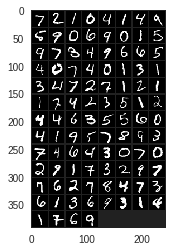

In [0]:
net.eval() # set the network in evaluation mode (as opposed to training mode; see comment above when we called net.train())

# load a set of example images from the testing set
dataiter = iter(testloader)
images, labels = dataiter.next()

num_examples = images.size()[0]

# plot the examples
imshow(torchvision.utils.make_grid(images))

# move the examples and the labels to the GPU if available (if the network is on the GPU, we have to move any data there before processing it!)
images = images.to(device)
labels = labels.to(device)

# compute predictions and bring them back to the CPU
outputs = net(images)
_, predictions = torch.max(outputs, 1)


#print(' '.join(('{}'.format(j) for j in labels)))
print("Ground truth: ", " ".join("{}".format(labels[j]) for j in range(num_examples)))
print("Predicted:    ", " ".join("{}".format(predictions[j]) for j in range(num_examples)))
print("Accuracy: {}%".format(100*(labels==predictions).sum()/num_examples))

## Visualize filters
The filters of the trained network can be visualized by using the same function we used to generate the images to send to TensorBoard during training (but you are encouraged to use TensorBoard and look at how the filters evolved from their initial state!).

Looking at the plot below, do you see any interesting pattern?

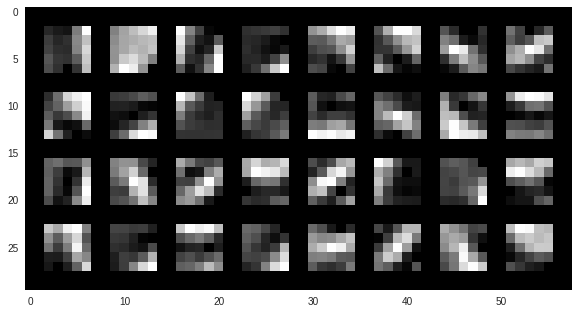

In [0]:
visualize_filters(net.conv1)

# Exercise

Now try to implement a convolutional network that performs image classification on [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 is an established computer-vision dataset used for object recognition. It is a subset of the [80 million tiny images dataset](http://people.csail.mit.edu/torralba/tinyimages/) and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. The object classes are the following:


0. Airplane
1. Automobile
2. Bird
3. Cat
4. Deer
5. Dog
6. Frog
7. Horse
8. Ship
9. Truck

<p><img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3649/media/cifar-10.png" alt="CIFAR sample images." style="width: 500px;"><br>Sample CIFAR images.</p>


Like MNIST, CIFAR is accessible [directly from within PyTorch](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar); the data loader interface should look very similar. You can start by implementing an architecture like the one we used for MNIST, and by training it in a similar way. **Note that the input is RGB color, and has a different size than MNIST (CIFAR is 3x32x32 while MNIST is 1x28x28), so you'll probably have to start by adjusting your architecture to cope with that**. After getting it to run, you can experiment with altering it to see what happens if you add, remove or change the size of filters, add or remove layers, etc.

---
Let's move to the next tutorial: [transfer learning](https://colab.research.google.com/drive/15exgMLrj7azSMQeKXBYwuHZAdJdCQloh).


In [0]:
# uncomment and run this if you want to delete all TensorBoard logs
#!rm -r $LOG_DIR